In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind

C:\Users\ms\AppData\Local\Temp\ipykernel_28488\429034463.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Description of the dataset

**Source of dataset:** https://www.kaggle.com/datasets/zynicide/wine-reviews

**Number of observations**

**Number of variables per observation**



In [2]:
df = pd.read_csv('winemag-data-130k-v2.csv')
df.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
115412,115412,US,"Stainless-steel fermented, this Sierra Foothil...",Solstice,88,20.0,California,Sierra Foothills,Sierra Foothills,Virginie Boone,@vboone,Sierra Starr 2011 Solstice Sauvignon Blanc (Si...,Sauvignon Blanc,Sierra Starr
61026,61026,US,"No oak on this semi-sweet, fruity Chardonnay. ...",NaN,84,13.0,California,California,California Other,NaN,NaN,Echelon 2010 Chardonnay (California),Chardonnay,Echelon
46179,46179,Germany,Delicate melon and white-peach aromas lend sof...,Blauschiefer,89,17.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Bastgen 2013 Blauschiefer Riesling (Mosel),Riesling,Bastgen
103583,103583,US,This 100% varietal wine comes from older plant...,Gamache Vineyards,88,40.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,William Church 2014 Gamache Vineyards Malbec (...,Malbec,William Church
113502,113502,Italy,"There's a sweet, floral touch at the open that...",Anno Zero Extra Dry,86,18.0,Veneto,Conegliano Valdobbiadene Prosecco Superiore,NaN,NaN,NaN,Valdellövo NV Anno Zero Extra Dry (Conegliano...,Glera,Valdellövo


**Meaning and type of the different variables**

In [3]:
df.dtypes

Unnamed: 0                 int64
country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

# Data Cleaning

The column "Unnamed: 0" is useless because count the number of the row 

Also 'taster_name' and 'taster_twitter_handle' are useless for us

In [4]:
df.drop(columns=['Unnamed: 0', 'taster_name', 'taster_twitter_handle'], inplace=True)

In [5]:
for column in df.columns:
    nan_count = df[column].isna().sum()
    unique_count = df[column].nunique()
    print(f"Column '{column}':")
    print(f"  Missing values: {nan_count}")
    print(f"  Unique values: {unique_count}")
    print()

Column 'country':
  Missing values: 63
  Unique values: 43

Column 'description':
  Missing values: 0
  Unique values: 119955

Column 'designation':
  Missing values: 37465
  Unique values: 37979

Column 'points':
  Missing values: 0
  Unique values: 21

Column 'price':
  Missing values: 8996
  Unique values: 390

Column 'province':
  Missing values: 63
  Unique values: 425

Column 'region_1':
  Missing values: 21247
  Unique values: 1229

Column 'region_2':
  Missing values: 79460
  Unique values: 17

Column 'title':
  Missing values: 0
  Unique values: 118840

Column 'variety':
  Missing values: 1
  Unique values: 707

Column 'winery':
  Missing values: 0
  Unique values: 16757



### Country column analysis

In [6]:
# Filter the DataFrame to show only rows where the specified column has NaN values
rows_with_nan = df[df['country'].isna()]
rows_with_nan

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
913,NaN,"Amber in color, this wine has aromas of peach ...",Asureti Valley,87,30.0,NaN,NaN,NaN,Gotsa Family Wines 2014 Asureti Valley Chinuri,Chinuri,Gotsa Family Wines
3131,NaN,"Soft, fruity and juicy, this is a pleasant, si...",Partager,83,NaN,NaN,NaN,NaN,Barton & Guestier NV Partager Red,Red Blend,Barton & Guestier
4243,NaN,"Violet-red in color, this semisweet wine has a...",Red Naturally Semi-Sweet,88,18.0,NaN,NaN,NaN,Kakhetia Traditional Winemaking 2012 Red Natur...,Ojaleshi,Kakhetia Traditional Winemaking
9509,NaN,This mouthwatering blend starts with a nose of...,Theopetra Malagouzia-Assyrtiko,92,28.0,NaN,NaN,NaN,Tsililis 2015 Theopetra Malagouzia-Assyrtiko W...,White Blend,Tsililis
9750,NaN,This orange-style wine has a cloudy yellow-gol...,Orange Nikolaevo Vineyard,89,28.0,NaN,NaN,NaN,Ross-idi 2015 Orange Nikolaevo Vineyard Chardo...,Chardonnay,Ross-idi
...,...,...,...,...,...,...,...,...,...,...,...
124176,NaN,This Swiss red blend is composed of four varie...,Les Romaines,90,30.0,NaN,NaN,NaN,Les Frères Dutruy 2014 Les Romaines Red,Red Blend,Les Frères Dutruy
129407,NaN,Dry spicy aromas of dusty plum and tomato add ...,Reserve,89,22.0,NaN,NaN,NaN,El Capricho 2015 Reserve Cabernet Sauvignon,Cabernet Sauvignon,El Capricho
129408,NaN,El Capricho is one of Uruguay's more consisten...,Reserve,89,22.0,NaN,NaN,NaN,El Capricho 2015 Reserve Tempranillo,Tempranillo,El Capricho
129590,NaN,"A blend of 60% Syrah, 30% Cabernet Sauvignon a...",Shah,90,30.0,NaN,NaN,NaN,Büyülübağ 2012 Shah Red,Red Blend,Büyülübağ


We have no knowledge of the country or the province or the region, so we have no idea of the origin of this wine.

### Drop duplicates

In total there are 129971 wine and is strange that the column "description" has 0 Missing values and 119955 Unique values

In [7]:
total_entries = df['description'].shape[0]
unique_entries = df['description'].nunique()

# Calculate the number of duplicate entries
duplicate_entries = total_entries - unique_entries

print(f"Number of duplicate entries in '{'description'}': {duplicate_entries}")

Number of duplicate entries in 'description': 10016


In [8]:
duplicated = df.duplicated().sum()
print(f"Total duplicate: {duplicated}")
df.drop_duplicates(inplace=True)

Total duplicate: 9983


In [9]:
total_entries = df['description'].shape[0]
unique_entries = df['description'].nunique()

# Calculate the number of duplicate entries
duplicate_entries = total_entries - unique_entries

print(f"Number of duplicate entries in '{'description'}': {duplicate_entries}")

Number of duplicate entries in 'description': 33


### Handle NaN

We want to replace NaN value with 0 in the Price column

In [10]:
nan_count = df['price'].isna().sum()
print("Before:")
print(f"total NaN in price: {nan_count}")
df['price'] = df['price'].fillna(0).astype('float64')
nan_count = df['price'].isna().sum()
print("After:")
print(f"total NaN in price: {nan_count}")

Before:
total NaN in price: 8395
After:
total NaN in price: 0


# Preprocessing

with this dataset is interesting create new columns, like price category and wine vintage

## Price Category column


at first we plot the histogram of the price to have a global idea

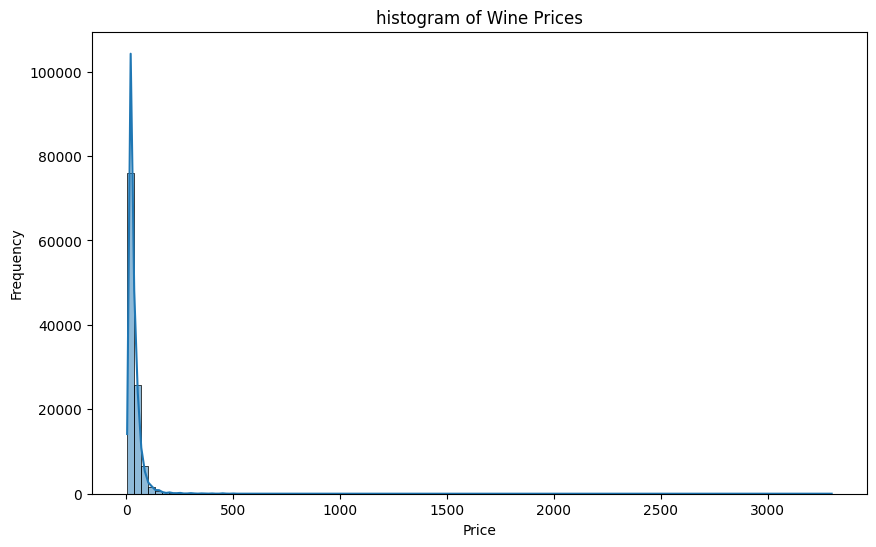

In [11]:
# Create a filtered DataFrame excluding rows where 'price' is 0 for the histogram
df_non_zero_price = df[df['price'] > 0]

plt.figure(figsize=(10, 6))
sns.histplot(df_non_zero_price['price'], bins=100, kde=True)
plt.title('histogram of Wine Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

0.33      20.0
0.66      35.0
1.00    3300.0
Name: price, dtype: float64
Low Price Range: 4.0 to 20.0
Medium Price Range: 20.0 to 35.0
High Price Range: 35.0 to 3300.0
   price price_category
1   15.0            Low
2   14.0            Low
3   13.0            Low
4   65.0           High
5   15.0            Low


C:\Users\ms\AppData\Local\Temp\ipykernel_28488\2043304545.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_zero_price['price_category'] = df_non_zero_price['price'].apply(categorize_price)


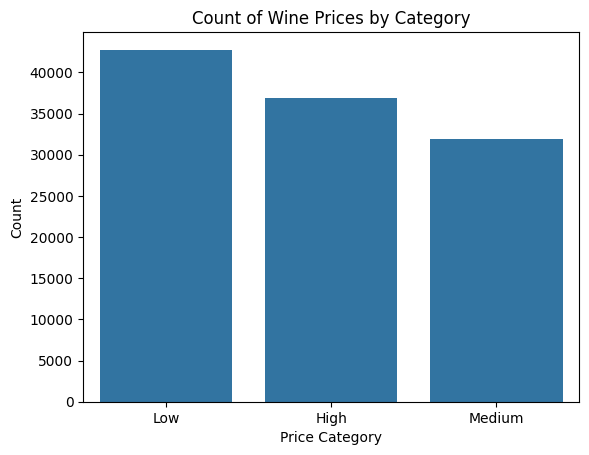

In [12]:

# Calculate quantiles
price_percentiles = df_non_zero_price['price'].quantile([0.33, 0.66, 1.0])
print(price_percentiles)

# Print the bounds for each category
low_bound = (df_non_zero_price['price'].min(), price_percentiles[0.33])
medium_bound = (price_percentiles[0.33], price_percentiles[0.66])
high_bound = (price_percentiles[0.66], df_non_zero_price['price'].max())

print(f"Low Price Range: {low_bound[0]} to {low_bound[1]}")
print(f"Medium Price Range: {medium_bound[0]} to {medium_bound[1]}")
print(f"High Price Range: {high_bound[0]} to {high_bound[1]}")

# Define categories based on the percentiles
def categorize_price(price):
    if price <= price_percentiles[0.33]:
        return 'Low'
    elif price <= price_percentiles[0.66]:
        return 'Medium'
    else:
        return 'High'

# Apply the function to create a new column
df_non_zero_price['price_category'] = df_non_zero_price['price'].apply(categorize_price)

# Check the new column
print(df_non_zero_price[['price', 'price_category']].head())

# Visualize the categorized data
sns.countplot(data=df_non_zero_price, x='price_category')
plt.title('Count of Wine Prices by Category')
plt.xlabel('Price Category')
plt.ylabel('Count')
plt.show()

## Wine Vintage column

In [13]:
import re
# Function to extract the vintage year from the title or description
def extract_vintage(row):
    # Try to find the year in the title first
    title_match = re.search(r'\b(19|20)\d{2}\b', row['title'])
    if title_match:
        return int(title_match.group(0))
    # If not found in title, try to find the year in the description
    description_match = re.search(r'\b(19|20)\d{2}\b', row['description'])
    if description_match:
        return int(description_match.group(0))
    # If not found in either, return None
    return None

# Apply the function to the dataframe to create the vintage column
df['vintage'] = df.apply(extract_vintage, axis=1)

nan_counts = df.isna().sum()
nan_counts
print("Number of NaN: ", nan_count)

# Converting the vintage column to integer type to remove the .0
df['vintage'] = df['vintage'].astype('Int64')

#new column check
df[['title', 'description', 'vintage']].head()


Number of NaN:  0


,title,description,vintage
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",2013
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",2011
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",2013
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",2013
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",2012


In [14]:
df

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery,vintage
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,0.0,Sicily & Sardinia,Etna,NaN,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),2013
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,2004
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,2012


# Data Exploration

 Analysis and visualisation of our data 

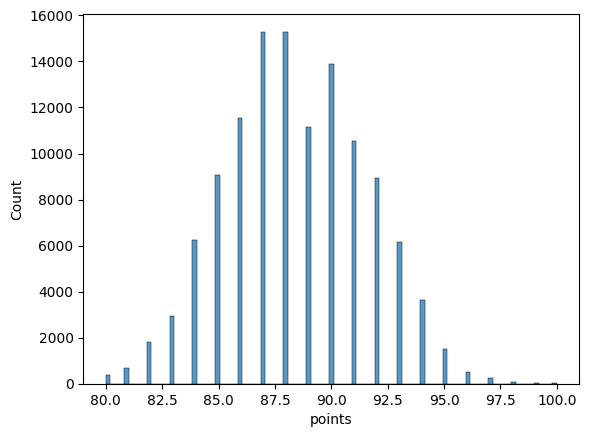

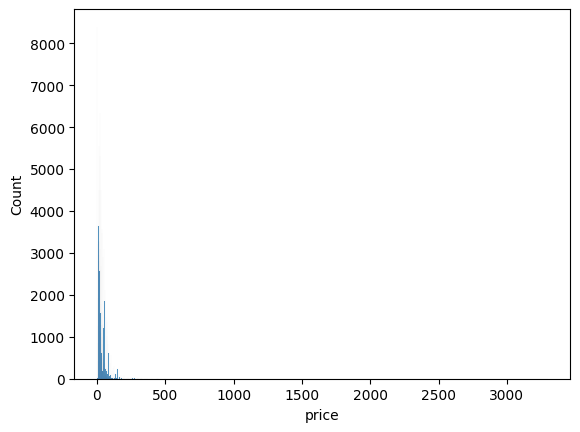

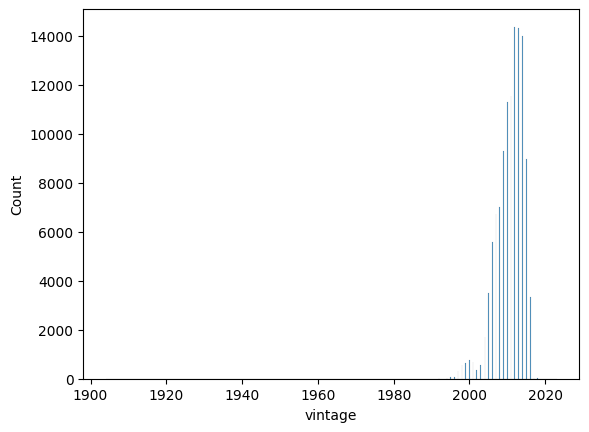

In [15]:
for i in df.select_dtypes(include="number").columns:
    sns.histplot(data=df, x=i)
    plt.show()

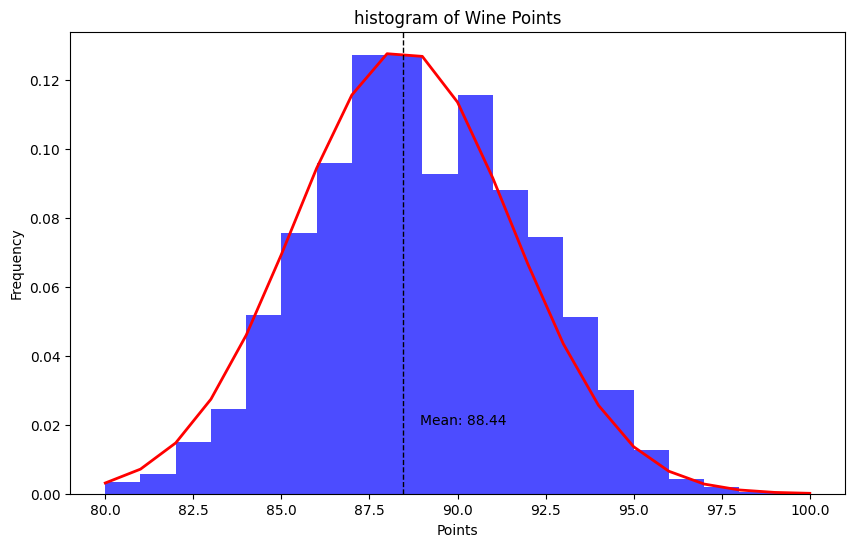

In [16]:
# Histogram of Wine Points
# Assuming 'points' is your column of interest
mean_points = df['points'].mean()
std_points = df['points'].std()

# Generate values for the normal distribution curve
normal_dist = stats.norm.pdf(sorted(df['points']), mean_points, std_points)

plt.figure(figsize=(10, 6))
plt.hist(df['points'], bins=20, density=True, color='blue', alpha=0.7)
plt.plot(sorted(df['points']), normal_dist, color='red', linewidth=2)
plt.title('histogram of Wine Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.axvline(mean_points, color='k', linestyle='dashed', linewidth=1)
plt.text(mean_points + 0.5, 0.02, f'Mean: {mean_points:.2f}', rotation=0)
plt.show()



In [17]:
import plotly.express as px
# Ensure the country data is clean
df['country'] = df['country'].fillna('Unknown')

# Count the number of wines per country
country_wine_counts = df['country'].value_counts().reset_index()
country_wine_counts.columns = ['country', 'count']

# Generate the world map
fig = px.choropleth(country_wine_counts,
                    locations="country",
                    locationmode='country names',
                    color="count",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="World Wine Distribution")
fig.update_layout(width=1200, height=600)
fig.show()

# Hypotesis testing

## state of three hypotesis testing:
1 - Null Hypothesis (H0): There is no difference in the average price of red wines and white wines.
    Alternative Hypothesis (H1): There is a significant difference in the average price of red wines compared to white wines.

2 - Null Hypothesis (H0): The mean rating of wines from 2000 onwards is equal to or less than the mean rating of wines produced before 2000.
    Alternative Hypothesis (H1): The mean rating of wines from 2000 onwards is higher than the mean rating of wines produced before 2000.

3 - Null hypothesis (H0): There is no difference in average points between wines from Italy and France.
    Alternative hypothesis (H1): There is a difference in average points between wines from Italy and France. 

In [18]:
# 3
italy_points = df[df['country'] == 'Italy']['points']
france_points = df[df['country'] == 'France']['points']

# Perform t-test
t_stat, p_value = ttest_ind(italy_points.dropna(), france_points.dropna())
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -9.733349596129866, P-value: 2.3069295011679336e-22


# Confidence Intervals

In [19]:
# Calculate mean and standard error
mean_points = df['points'].mean()
sem_points = stats.sem(df['points'].dropna())

# Calculate the confidence interval
confidence_interval = stats.t.interval(0.95, len(df['points'].dropna())-1, loc=mean_points, scale=sem_points)
print(f'95% Confidence Interval for the Mean Points of Wines: {confidence_interval}')

95% Confidence Interval for the Mean Points of Wines: (88.42473534460282, 88.45973643590855)


In [20]:
# Calculate mean and standard error
mean_price = df['price'].mean()
sem_price = stats.sem(df['price'].dropna())

# Calculate the confidence interval
confidence_interval = stats.t.interval(0.95, len(df['price'].dropna())-1, loc=mean_price, scale=sem_price)
print(f'95% Confidence Interval for the Mean Price of Wines: {confidence_interval}')

95% Confidence Interval for the Mean Price of Wines: (32.89309808840795, 33.36396095082931)


# Linear Regression and correlation analysis

## Scatterplots and Correlation

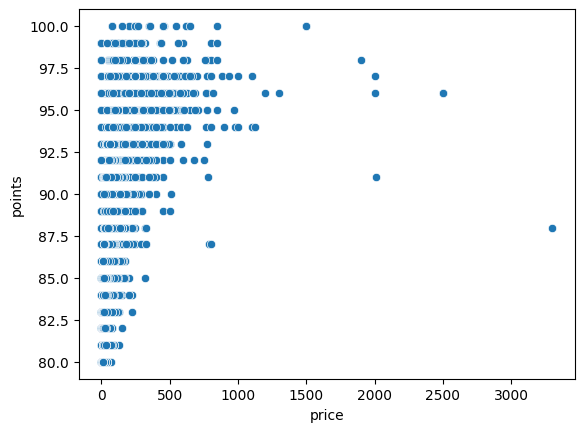

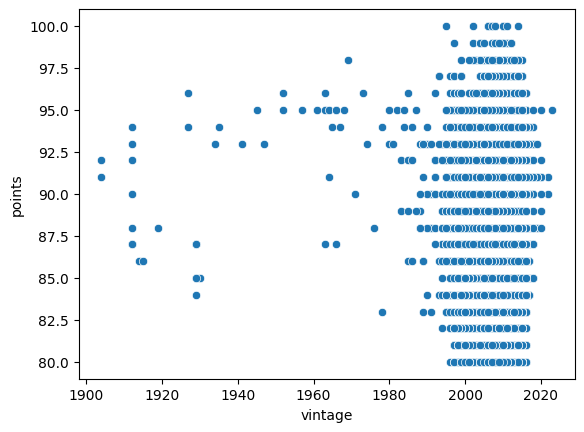

In [21]:
for i in ['price', 'vintage']:
    sns.scatterplot(data=df, x=i, y="points")
    plt.show()


<Figure size 1200x800 with 0 Axes>

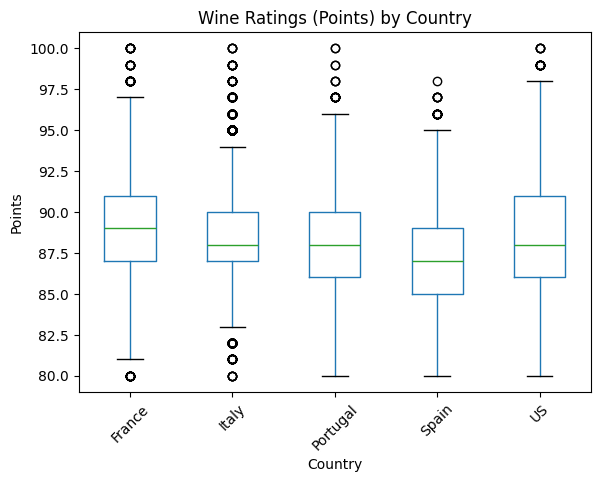

In [33]:
# Select top 10 countries by the number of wine reviews
top_countries = df['country'].value_counts().head(5).index
top_countries_data = df[df['country'].isin(top_countries)]

# Box plot for points by country
plt.figure(figsize=(12, 8))
top_countries_data.boxplot(column='points', by='country', grid=False)
plt.title('Wine Ratings (Points) by Country')
plt.suptitle('')
plt.xlabel('Country')
plt.ylabel('Points')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

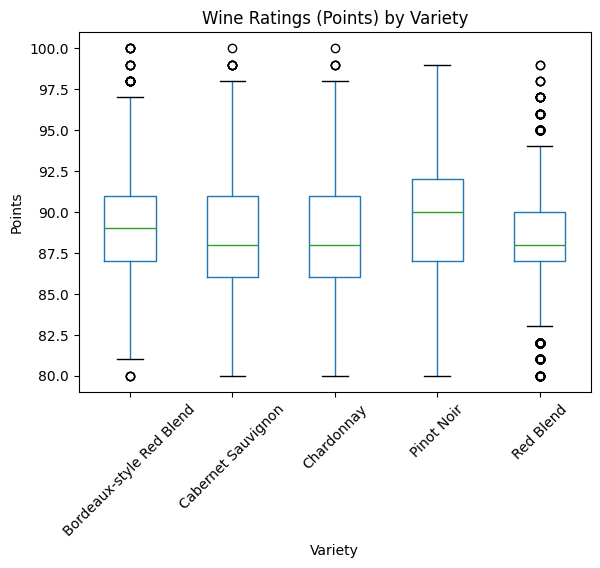

In [34]:
# Select top 10 varieties by the number of wine reviews
top_varieties = df['variety'].value_counts().head(5).index
top_varieties_data = df[df['variety'].isin(top_varieties)]

# Box plot for points by variety
plt.figure(figsize=(12, 8))
top_varieties_data.boxplot(column='points', by='variety', grid=False)
plt.title('Wine Ratings (Points) by Variety')
plt.suptitle('')
plt.xlabel('Variety')
plt.ylabel('Points')
plt.xticks(rotation=45)
plt.show()

# Conclusions